# Compton Effekt

## initial imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as con
import uncertainties as un
import uncertainties.unumpy as unp
from scipy.signal import find_peaks,find_peaks_cwt
import scipy.signal as sig
import scienceplots
plt.figure()
plt.style.use('science')
import os
if not os.path.exists('Compton/output'):
    os.makedirs('Compton/output')

<Figure size 432x288 with 0 Axes>

In [3]:
# normalize
def normalize(arr, t_min, t_max):
    arr = arr.to_numpy()
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
def simple_norm(arr):
    arr = arr.to_numpy()
    norm_arr = []
    diff = 1
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr)
        norm_arr.append(temp)
    return norm_arr
def norm2(arr):
    arr = arr.to_numpy()
    diff_arr = max(arr) - min(arr)   
    return arr/diff_arr

def mapcolors(n):
    """Return a list of n colors from the default colormap"""
    return [plt.cm.jet(int(x*plt.cm.jet.N/n)) for x in range(n)]

## 1 Kalibrierung

### import data

In [4]:
co60_kalib = pd.read_csv('Compton/data_alt/Kalibrierung_Punkt1/Co60_Kalibrierung.txt', sep='\t', header=None, names=['channel', 'counts'])
cs137_kalib = pd.read_csv('Compton/data_alt/Kalibrierung_Punkt1/Cs137_Kalibrierung.txt', sep='\t', header=None, names=['channel', 'counts'])
na22_kalib = pd.read_csv('Compton/data_alt/Kalibrierung_Punkt1/Na22_Kalibrierung.txt', sep='\t', header=None, names=['channel', 'counts'])
kalib_energies = unp.uarray([1173.2,1333,662,511],12)

co60_kalib

,channel,counts
0,0,132
1,1,752
2,2,725
3,3,717
4,4,768
...,...,...
251,251,6
252,252,6
253,253,7
254,254,9


### analyze data

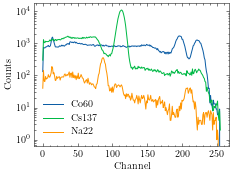

In [5]:
plt.plot(co60_kalib['channel'], co60_kalib['counts'], label='Co60')
plt.plot(cs137_kalib['channel'], cs137_kalib['counts'], label='Cs137')
plt.plot(na22_kalib['channel'], na22_kalib['counts'], label='Na22')
plt.legend()

plt.xlabel('Channel')
plt.ylabel('Counts')

plt.yscale('log')

array([196, 222])

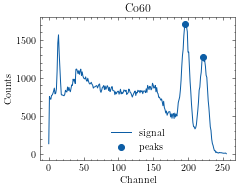

In [6]:
x,y= co60_kalib['channel'], co60_kalib['counts']
plt.plot(x,y,label='signal')

c60_peaks, _= sig.find_peaks(y, height=1200, distance=20,width=10)
plt.scatter(x[c60_peaks],y[c60_peaks], label='peaks')

plt.title('Co60')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()

c60_peaks

array([113])

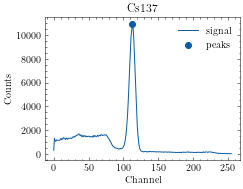

In [7]:
x,y= cs137_kalib['channel'], cs137_kalib['counts']
plt.plot(x,y,label='signal')

cs137_peaks, _= sig.find_peaks(y, height=4000, distance=20)
plt.scatter(x[cs137_peaks],y[cs137_peaks], label='peaks')

plt.title('Cs137')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()

cs137_peaks

array([87])

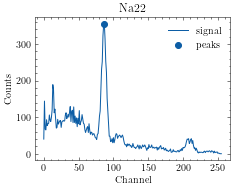

In [8]:
x,y= na22_kalib['channel'],na22_kalib['counts']
plt.plot(x,y,label='signal')

na22_peaks, _= sig.find_peaks(y, height=200, distance=20)
plt.scatter(x[na22_peaks],y[na22_peaks], label='peaks')

plt.title('Na22')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()

na22_peaks

In [9]:
def linfit(x,a,b):
    return a*x+b

In [10]:
kalib_channels = np.array([])
kalib_channels = np.append(kalib_channels,c60_peaks)
kalib_channels = np.append(kalib_channels,cs137_peaks)
kalib_channels = np.append(kalib_channels,na22_peaks)
kalib_channels = unp.uarray(kalib_channels, 2)
kalib_channels,kalib_energies

(array([196.0+/-2.0, 222.0+/-2.0, 113.0+/-2.0, 87.0+/-2.0], dtype=object),
 array([1173.2+/-12.0, 1333.0+/-12.0, 662.0+/-12.0, 511.0+/-12.0],
       dtype=object))

a = 6.11(4)keV/chn 	 b = -24+/-6keV


Text(0, 0.5, 'Energie [keV]')

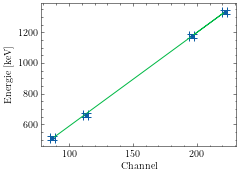

In [11]:
x ,y = unp.nominal_values(kalib_channels),unp.nominal_values(kalib_energies)
xerr,yerr = unp.std_devs(kalib_channels),unp.std_devs(kalib_energies)

plt.errorbar(x,y,yerr,xerr,fmt='.',capsize=5)

c,cov = curve_fit(linfit,x,y,sigma=yerr)
perr=np.sqrt(np.diag(cov))
plt.plot(x,linfit(x,*c),label='fit')

a = unp.uarray(c[0],perr[0])
b = unp.uarray(c[1],perr[1])
print(f'a = {a:S}keV/chn \t b = {b}keV')

def energy(channel):
    return a*channel+b

plt.xlabel('Channel')
plt.ylabel('Energie [keV]')

## 2 Streuwinkel

### import data

In [12]:
streuwinkel = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
streuwinkel = unp.uarray(streuwinkel,0.5)
streu_data = []*len(streuwinkel)
for i in streuwinkel:
    streu_data.append(pd.read_csv(f'Compton/data_alt/Streuwinkel_Punkt2/Cs137_{int(i.n)}grad.txt', sep='\t', header=None, names=['channel', 'counts']))
streu_data[len(streu_data)-1]

,channel,counts
0,0,4
1,1,19
2,2,9
3,3,7
4,4,10
...,...,...
251,251,0
252,252,1
253,253,0
254,254,0


### analyze data

Text(0, 0.5, 'Counts')

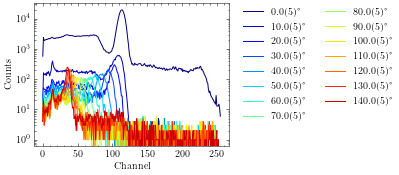

In [13]:
for i in range(len(streu_data)):
    plt.plot(streu_data[i]['channel'], streu_data[i]['counts'], label=f'{streuwinkel[i]:S}°',color=mapcolors(len(streu_data))[i])
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)


plt.xlabel('Channel')
plt.ylabel('Counts')

0.0(5)°: 672(7)keV
10.0(5)°: 636(7)keV
20.0(5)°: 605(7)keV
30.0(5)°: 550(7)keV
40.0(5)°: 501(7)keV
50.0(5)°: 440(6)keV
60.0(5)°: 398(6)keV
70.0(5)°: 336(6)keV
80.0(5)°: 312(6)keV
90.0(5)°: 282(6)keV
100.0(5)°: 257(6)keV
110.0(5)°: 227(6)keV
120.0(5)°: 220(6)keV
130.0(5)°: 208(6)keV
140.0(5)°: 190(6)keV


Text(0.5, 0, 'Energie [keV]')

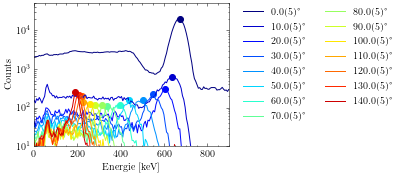

In [37]:
streu_energies = np.array([])
for i in range(len(streu_data)):
    x,y = energy(streu_data[i]['channel']), streu_data[i]['counts']
    plt.plot(unp.nominal_values(x),y, label=f'{streuwinkel[i]:S}°',color=mapcolors(len(streu_data))[i])
    peaks, _= sig.find_peaks(y, height=100, distance=20,width=4,prominence=max(y)/5)
    plt.scatter(unp.nominal_values(x[peaks]),y[peaks], color=mapcolors(len(streu_data))[i])
    if (len(peaks)==1):
        print(f'{streuwinkel[i]:S}°: {energy(peaks[0]):S}keV')
        streu_energies = np.append(streu_energies,energy(peaks[0]))
    elif (len(peaks)==0):
        print(f'{streuwinkel[i]:S}°: no peak found')
    else:
        print(f'{streuwinkel[i]:S}°: too many peaks')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)
plt.xlim(0,900)
plt.ylim(10,50000)
plt.ylabel('Counts')
plt.xlabel('Energie [keV]')

Text(0, 0.5, 'Energie [keV]')

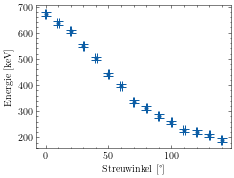

In [39]:
plt.errorbar(unp.nominal_values(streuwinkel),unp.nominal_values(streu_energies),unp.std_devs(streu_energies),unp.std_devs(streuwinkel),fmt='.',capsize=5)
plt.xlabel('Streuwinkel [°]')
plt.ylabel('Energie [keV]')

## 3 Rückstoßelektronen

### import data

In [15]:
rueckstoss_data = pd.read_csv('Compton/data_alt/Rückstosselektronen_Punkt3/Spektrum_Rückstosselektronen.txt', sep='\t', header=None, names=['channel', 'counts'])

### analyze data

Text(0, 0.5, 'Counts')

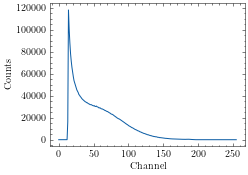

In [16]:
plt.plot(rueckstoss_data['channel'], rueckstoss_data['counts'], label='Rückstosselektronen')

plt.xlabel('Channel')
plt.ylabel('Counts')

## 4 Koinzidenz

### import data

In [17]:
koinzidenz_winkel = [30, 50, 80, 110, 140]
koinzidenz_winkel = unp.uarray(koinzidenz_winkel,0.5)
koinzidenz_data = []*len(koinzidenz_winkel)
for i in koinzidenz_winkel:
    koinzidenz_data.append(pd.read_csv(f'Compton/data_alt/Koinzidenz_Punkt4/Koinzidenz_Messung_{int(i.n)}grad.txt', sep='\t', header=None, names=['count1', 'count2']))

### analyze data

Text(0, 0.5, 'Count 2')

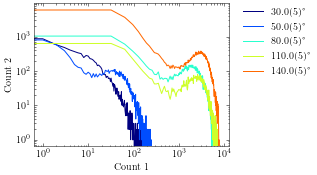

In [18]:
for i in range(len(koinzidenz_data)):
    plt.plot(koinzidenz_data[i]['count1'], koinzidenz_data[i]['count2'], label=f'{koinzidenz_winkel[i]:S}°',color=mapcolors(len(koinzidenz_data))[i])
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel('Count 1')
plt.ylabel('Count 2')

## 5 Energien der Photopeaks

## 6 Ruhemasse des Elektrons

## 7/8 Streuquerschnitt